<a href="https://colab.research.google.com/github/anshupandey/Generative-Adversial-Networks/blob/master/GAN_keras_python_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras import models
from keras import layers
from keras.optimizers import SGD
from keras.datasets import mnist
import numpy
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# Generator Model

In [11]:
model1 = models.Sequential()
model1.add(layers.Dense(input_dim=100,output_dim=1024))
model1.add(layers.Activation('tanh'))
model1.add(layers.Dense(128*7*7))
model1.add(layers.Activation('tanh'))
model1.add(layers.BatchNormalization())
model1.add(layers.Activation("tanh"))
model1.add(layers.Reshape((7,7,128),input_shape=(128*7*7,)))
model1.add(layers.UpSampling2D(size=(2,2)))
model1.add(layers.Conv2D(64,(5,5),padding='same'))
model1.add(layers.Activation('tanh'))
model1.add(layers.UpSampling2D(size=(2,2)))
model1.add(layers.Activation('tanh'))
model1.add(layers.Conv2D(1,(5,5),padding='same'))
model1.add(layers.Activation('tanh'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, units=1024)`
  


# Dsicriminator

In [0]:
model2 = models.Sequential()
model2.add(layers.Conv2D(64,(5,5),padding='same',input_shape=(28,28,1)))
model2.add(layers.Activation('tanh'))
model2.add(layers.MaxPooling2D(pool_size=(2,2)))
model2.add(layers.Conv2D(128,(5,5)))
model2.add(layers.Activation('tanh'))
model2.add(layers.MaxPooling2D(pool_size=(2,2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(1024))
model2.add(layers.Activation('tanh'))
model2.add(layers.Dense(1))
model2.add(layers.Activation('sigmoid'))

# Final Model

In [0]:
model = models.Sequential()
model.add(model1)
model2.trainable = False
model.add(model2)

# load data

In [28]:
(trainimg,trainlb),(testimg,testlb) = mnist.load_data()
trainimg = (trainimg.astype(numpy.float32) - 127.5)/127.5
trainimg = trainimg.reshape(60000,28,28,1)
testimg = testimg.reshape(10000,28,28,1)
trainimg.shape

(60000, 28, 28, 1)

# Combining Images

In [0]:
def combine_images(g_images):
    num = g_images.shape[0] # getting the count of images
    width = int(numpy.sqrt(num))
    height = int(numpy.ceil(float(num)/width))
    imgshape = g_images.shape[1:3]
    image = numpy.zeros((height*imgshape[0],width*imgshape[1]),dtype = g_images.dtype)
    for ind,img in enumerate(g_images):
        i = int(ind/width)
        j = ind % width
        image[i*imgshape[0]:(i+1)*imgshape[0],j*imgshape[1]:(j+1)*imgshape[1]] = img[:,:,0]
        return image
    
    

# Compilation and Training

In [0]:
model1_optim = SGD(lr = 0.0005,momentum=0.9)
model2_optim = SGD(lr = 0.0005,momentum=0.9)
model1.compile(loss='binary_crossentropy',optimizer="SGD")
model.compile(loss='binary_crossentropy',optimizer=model1_optim)
model2.trainable = True
model2.compile(loss='binary_crossentropy',optimizer=model2_optim)
# training for 100 epochs
for i in range(100):
    print("Epoch is ",i)
    batch_size = 128
    for j in range(int(trainimg.shape[0]/batch_size)):
        noise = numpy.random.uniform(-1,1,size=(batch_size,100))
        img_batch = trainimg[j*batch_size:(j+1)*batch_size]
        g_images = model1.predict(noise,verbose=0)
        if j % 20 ==0:
            img = combine_images(g_images)
            img = img*127.5 + 127.5
            Image.fromarray(img.astype(numpy.uint8)[:28,:28]).save("generated_pictures\\"+str(i)+"_"+str(j)+".png")
            xtrain = numpy.concatenate((img_batch,g_images))
            ytrain = [1]*batch_size +[0] * batch_size
            model2_loss = model2.train_on_batch(xtrain,ytrain)
            print("batch %d discriminator loss : %f"%(j,model2_loss))
            noise = numpy.random.uniform(-1,1,(batch_size,100))
            model2.trainable = False
            model1_loss = model.train_on_batch(noise,[1]*batch_size)
            model2.trainable = True
            print("batch %d generator loss : %f"%(j,model1_loss))

In [0]:
model1.save_weights("generator",True)
model2.save_weights("discriminator",True)

# Generation

In [44]:
model1.compile(loss='binary_crossentropy',optimizer="SGD")
model1.load_weights('generator')
noise = numpy.random.uniform(-1,1,(batch_size,100))
g_iamges2 = model1.predict(noise,verbose=1)
img = combine_images(g_iamges2)
img = img*127.5 + 127.5
Image.fromarray(img.astype(numpy.uint8)[:28,:28]).save("generated_image.png")

128/128 [==============================] - 0s 1ms/step


In [45]:
img = cv2.imread("generated_image.png")
img.shape

(28, 28, 3)

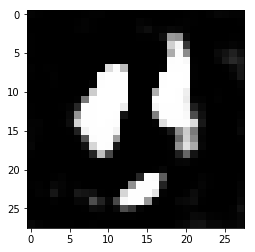

In [46]:
plt.imshow(img)
plt.show()

In [47]:
# Generating fine tuned images
model1.compile(loss='binary_crossentropy',optimizer="SGD")
model1.load_weights('generator')
model2.compile(loss='binary_crossentropy',optimizer="SGD")
model2.load_weights('discriminator')
noise = numpy.random.uniform(-1,1,(batch_size*20,100))
g_iamges2 = model1.predict(noise,verbose=1)
model2_pred = model2.predict(g_iamges2,verbose=1)
ind = numpy.arange(0,batch_size*20)
ind.resize((batch_size*20,1))
pre_with_ind = list(numpy.append(model2_pred,ind,axis=1))
pre_with_ind.sort(key = lambda x:x[0],reverse=True)
fine_img = numpy.zeros((batch_size,)+g_iamges2.shape[1:3],dtype='float32')
fine_img = fine_img[:,:,:,None]
for i in range(batch_size):
    idx = int(pre_with_ind[i][1])
    fine_img[:,:,:,0] = g_iamges2[idx,:,:,0]
img = combine_images(fine_img)
img = img*127.5 + 127.5
Image.fromarray(img.astype(numpy.uint8)[:28,:28]).save("generated_image.png")


2560/2560 [==============================] - 0s 117us/step


In [48]:
img = cv2.imread("generated_image.png")
img.shape

(28, 28, 3)

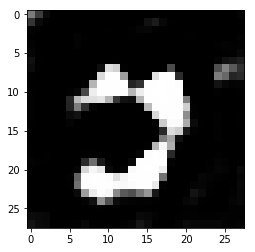

In [49]:
plt.imshow(img)
plt.show()